## Description
This version uses cell detection from TK's CNN neural network and demixing from Johannes's algorithm.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1. Load denoised data

In [2]:
Y = np.load('tmpData/Ytd.npy')

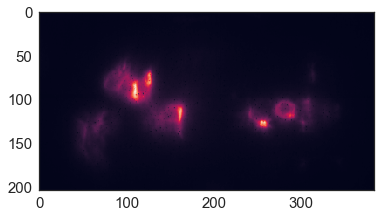

In [3]:
ave = Y.mean(axis=-1)
plt.imshow(ave)
plt.show()

## 2. Identify neurons using CNN  

In [4]:
from roiDemixing import Imfc as im
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_fill_holes
from keras.models import load_model
from keras import backend as K
K.set_image_dim_ordering('th') # color channel first

Using Theano backend.


In [5]:
cell_radius=5
rank_radius=int(cell_radius*1.5)
model = load_model('../roiDemixing/cell_model_32.hdf5')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### 2.1 Mask the continuous area with high signals

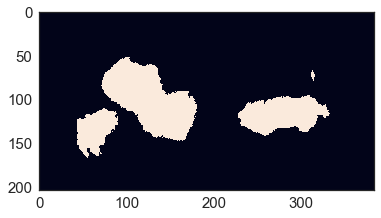

In [6]:
br_threshold1 = Y.std()
mask=binary_fill_holes(ave>br_threshold1)
plt.imshow(mask)
plt.show()

### 2.2 Find local minima as initalization of cell centers

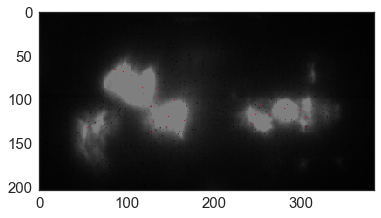

In [7]:
rank_image=gaussian_filter(im.imrank_dll(gaussian_filter(ave,cell_radius*0.2),rank_radius),cell_radius*0.2)
minima_image=im.local_minima_dll(rank_image,int(cell_radius*1.5))
overlay=np.tile(im.imNormalize(ave,95)[:,:,None],(1,1,3))/2
cell_centers=np.where((minima_image>0) & mask)
cell_centers_yx=np.array([cell_centers[0],cell_centers[1]]).T
# mark the cell center in red
overlay[cell_centers[0],cell_centers[1],0]=1
overlay[cell_centers[0],cell_centers[1],1]=0
overlay[cell_centers[0],cell_centers[1],2]=0
plt.imshow(overlay)
plt.show()

### 2.3 Network correction for the cells

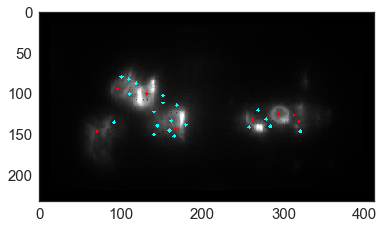

In [8]:
image_radius=14
v1=ave.mean()
v2=ave.std()
ave_pad=(np.random.randn(ave.shape[0]+image_radius*2,ave.shape[1]+image_radius*2)*np.sqrt(v2))+v1
ave_pad[image_radius:-image_radius,image_radius:-image_radius]=ave
rank_pad=np.zeros((ave.shape[0]+image_radius*2,ave.shape[1]+image_radius*2))
rank_pad[image_radius:-image_radius,image_radius:-image_radius]=rank_image

cell_r=cell_centers[0][np.where(cell_centers[0]>cell_radius*2)] # this line is unnecessary????
cell_r=cell_centers[0]
cell_c=cell_centers[1]

imlist=np.zeros((len(cell_r),1,image_radius*2+1,image_radius*2+1))
classlist=np.zeros((len(cell_r),))
for i in range(len(cell_r)):
    imlist[i,0,:,:]=im.imNormalize(ave_pad[cell_r[i]:(cell_r[i]+image_radius*2+1), \
          cell_c[i]:(cell_c[i]+image_radius*2+1)],99)[None,None,:,:]

scores=model.predict(imlist)
label=(scores[:,0]>0.5).astype('int')
label[np.where(label==0)]=2

inds1=np.where(label==1)[0]
inds2=np.where(label==2)[0]

disk=im.makeDisk(2)
disk_r=np.where(disk>0)[0]-2
disk_c=np.where(disk>0)[1]-2
cell_image=np.tile(im.imNormalize(ave,99.9)[:,:,None],(1, 1, 3))
cell_image_pad=np.zeros((cell_image.shape[0]+image_radius*2,cell_image.shape[1]+image_radius*2,3))
cell_image_pad[image_radius:-image_radius,image_radius:-image_radius,:]=cell_image
cell_image_pad2=cell_image_pad.copy()
for i in range(len(cell_r)):
    if label[i]==1:
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,0]=1
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,1]=0
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,2]=0
    if label[i]==2:
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,0]=0
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,1]=1
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,2]=1

plt.imshow(cell_image_pad)
plt.show()

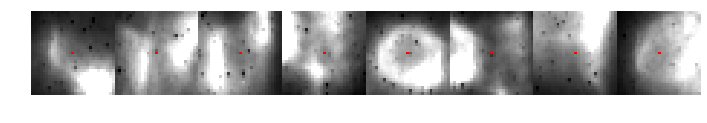

In [9]:
im.cell_images(imlist,inds1)

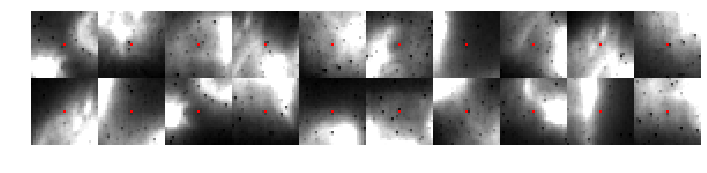

In [10]:
im.cell_images(imlist,inds2)

### 2.3 Manual proof of cell ROIs -- skip....

In [11]:
ROI_inds=im.draw_periphery(ave,cell_r,cell_c,cell_radius*2)
ROI_inds = [ROI_inds[_] for _ in inds1]

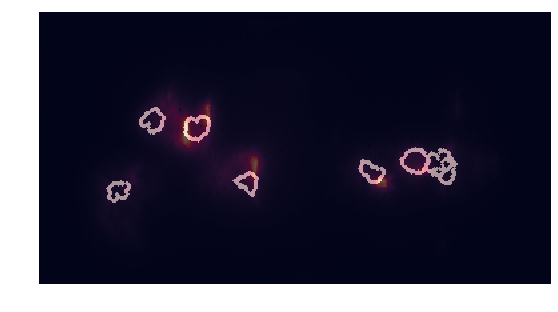

In [12]:
mask = ave>br_threshold1
mask[:] = False
for ROI_ in ROI_inds:
    for x, y in zip(ROI_[0], ROI_[1]):
        mask[x, y] = True
plt.figure(figsize=(15, 5))
plt.imshow(ave)
plt.imshow(mask, alpha=0.6)
plt.axis('off')
plt.show()

In [13]:
# np.save("tmpData/Y_ROI_inds.npy",ROI_inds)

#### Optimal tools -- Flika

http://flika-org.github.io/index.html

## 3. NMF

In [14]:
Y_stack = Y.transpose([2, 0, 1])

In [15]:
from roiDemixing import ROI
ROI_opt = []
for ROI_ in ROI_inds:
    ROI_opt.append(ROI.optimize_trace(Y_stack, ave, ROI_, use_NMF=True))

-----------
 start optimizing
79 spikes found
optimizing ROI
Use NMF
77 spikes found
-----------
 start optimizing
13 spikes found
not active cell
-----------
 start optimizing
16 spikes found
not active cell
-----------
 start optimizing
0 spikes found
not active cell
-----------
 start optimizing
82 spikes found
optimizing ROI
Use NMF
1 spikes found
reconsider as non active cell
 first_timecourse saved
-----------
 start optimizing
0 spikes found
not active cell
-----------
 start optimizing
0 spikes found
not active cell
-----------
 start optimizing
0 spikes found
not active cell


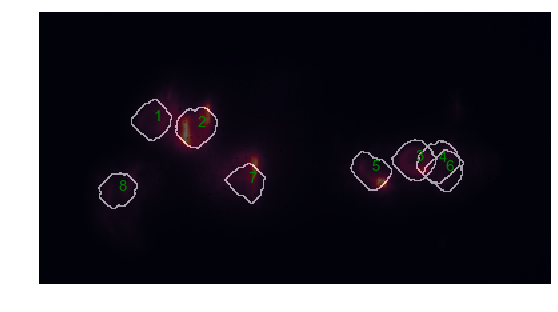

In [16]:
from skimage.filters import roberts
mask = ave>br_threshold1
mask[:] = False
mask_ = mask.copy()
plt.figure(figsize=(15, 5))
plt.imshow(ave)
for ROI_ in ROI_opt:
    mask_[:] = False
    for x, y in zip(ROI_['ROI_Y'], ROI_['ROI_X']):
        mask_[x, y] = True
    mask[roberts(mask_)>0] = True
plt.imshow(mask, alpha =0.6, cmap=plt.cm.gray)
# put labels
for idx, ROI_ in enumerate(ROI_opt):
    plt.text(ROI_['ROI_X'][0].mean(), ROI_['ROI_Y'][0].mean(), idx+1, color='green', fontsize=15)
plt.axis('off')
plt.show()

In [17]:
ROI_traces = []
ROI_spike = []
for ROI_ in ROI_opt:
    if ROI_['active'][0] == 0:
        ROI_traces.append(ROI_['raw_tcourse1'][0])
        ROI_spike.append(ROI_['spike_tcourse1'][0])
    else:
        ROI_traces.append(ROI_['raw_tcourse2'][0])
        ROI_spike.append(ROI_['spike_tcourse2'][0])

## 4. Trend filtering

### 4.1 L1TF

In [18]:
from scipy import signal
from trefide.solvers.lagrangian import lpdas, ipm
from trefide.solvers.constrained import cpdas
from peakutils import peak
from scipy.sparse.linalg import lsqr, lsmr

def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
#     D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n).todense()
#     return np.linalg.norm(np.dot(np.linalg.pinv(D.T), y), ord=np.inf)
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
    x, istop, itn, normr = lsmr(D.T, y)[:4]
    return np.linalg.norm(x, ord=np.inf)

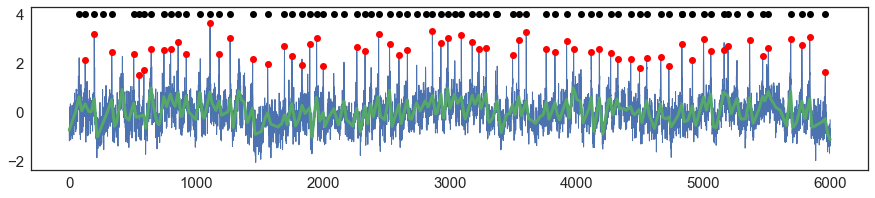

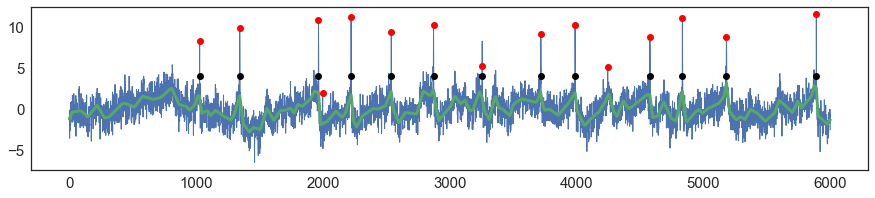

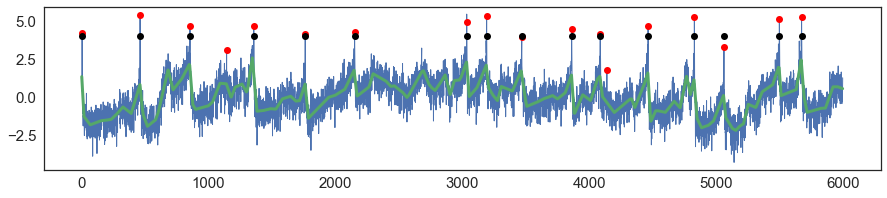

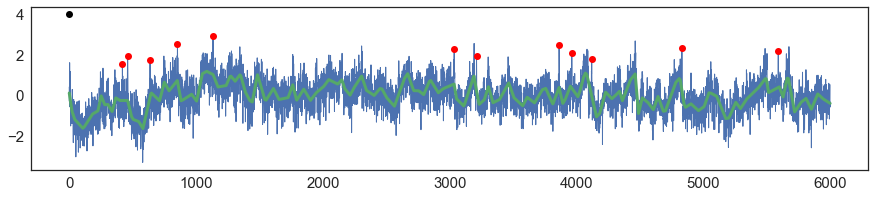

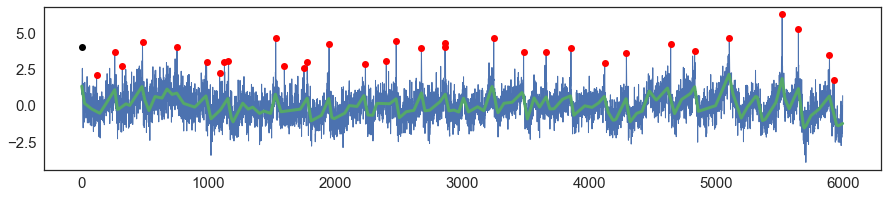

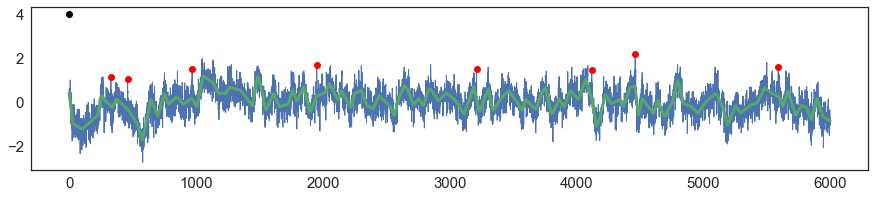

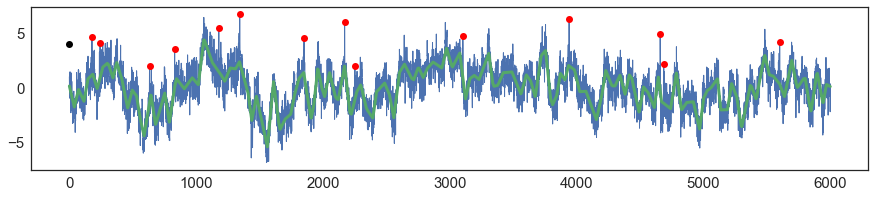

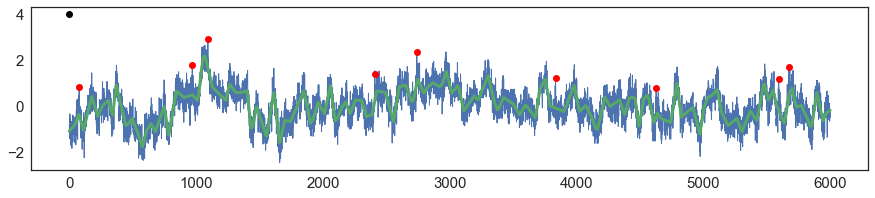

In [21]:
nTime = Y_stack.shape[0]
for spk, y in zip(ROI_spike, ROI_traces):
    if len(y) == nTime:
        y_ = y.astype(np.double)
        y_detr = -signal.detrend(y_)
        lam = lambda_max_D2(y_detr)
        x_, _, _ = lpdas(y_detr, lam/20, wi=None, z_hat=None, p = 1, m=5, delta_s=.9, delta_e=1.1, maxiter=2000, verbose=0)
        x_ = np.array(x_)
        # plots    
        plt.figure(figsize=(15, 3))
        plt.plot(y_detr, linewidth=1)
        plt.plot(x_, linewidth=3)
        spk_ind = np.array(np.where((y_detr-x_-(y_detr-x_).mean())/(y_detr-x_).std()>3)).flatten()
        diff_ind = spk_ind[1:] - spk_ind[:-1]
        spk_ind_ = np.delete(spk_ind, np.array(np.where(diff_ind==1))+1)
        plt.plot(spk_ind_,y_detr[spk_ind_], 'or')
        if not (spk>1).any():
            plt.plot(np.array(np.where(spk==1)).flatten(), spk[spk==1]*4, 'ok')
        plt.show()

### peak search
```python
spk_ind_ = signal.find_peaks_cwt(x_, np.arange(1, 30))
spk_ind_ = peak.indexes(x_, thres=1)
spk_ind_ = np.array(np.where((y_detr-x_-(y_detr-x_).mean())/(y_detr-x_).std()>3))
```

### 4.2 L2TF (HP filter)

In [22]:
import statsmodels.api as sm
_, x_ = sm.tsa.filters.hpfilter(y_detr, 1000)

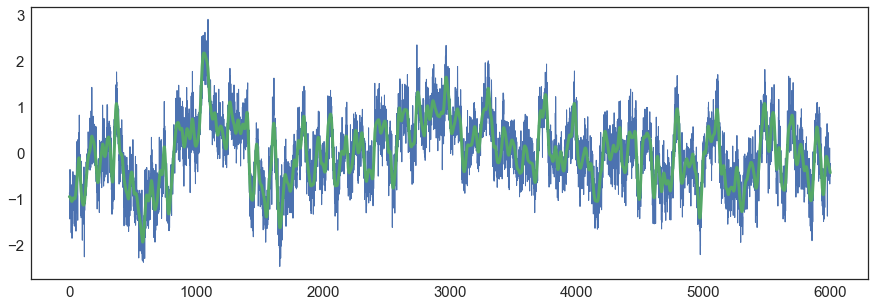

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(y_detr, linewidth=1)
plt.plot(x_, linewidth=3)
# plt.xlim([0, 1000])

### 4.3 Remove slow components in the activity -- Savitzky-Golay fit

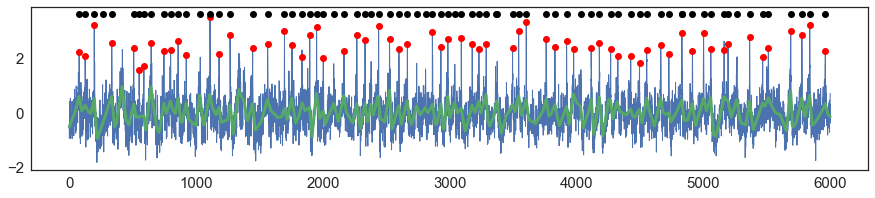

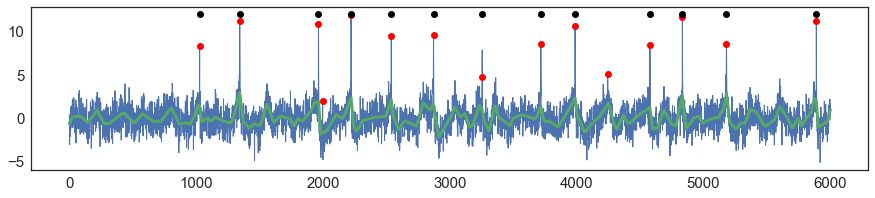

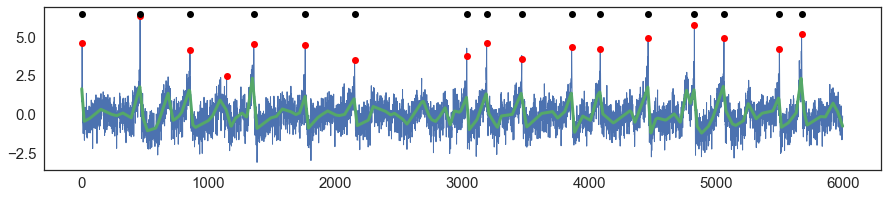

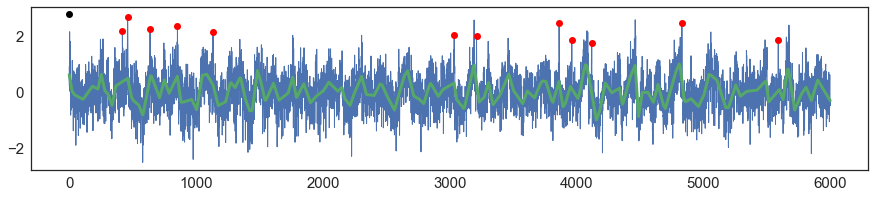

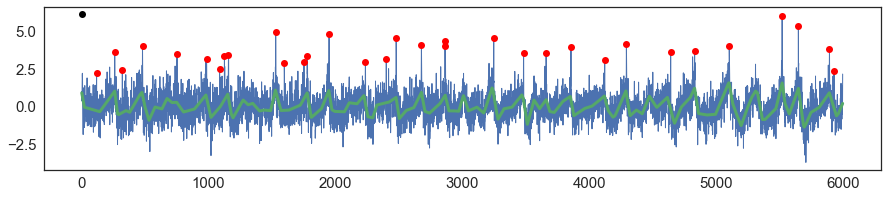

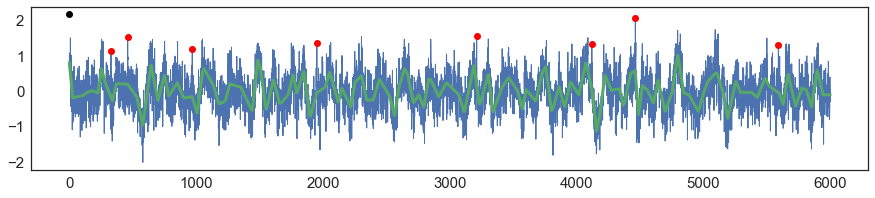

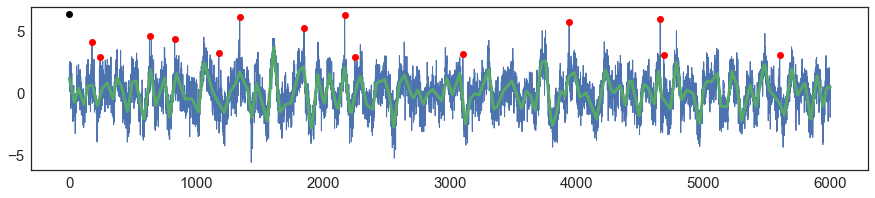

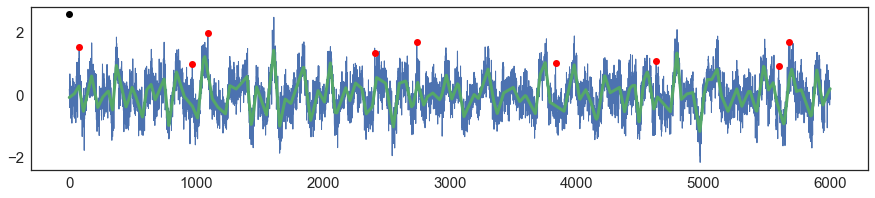

In [25]:
nTime = Y_stack.shape[0]
for spk, y in zip(ROI_spike, ROI_traces):
    if len(y) == nTime:
        y_ = y.astype(np.double)
        x_sg = signal.savgol_filter(y, 511, 3)
        y_detr = -(y_ - x_sg)
        lam = lambda_max_D2(y_detr)
        x_, _, _ = lpdas(y_detr, lam/20, wi=None, z_hat=None, p = 1, m=5, delta_s=.9, delta_e=1.1, maxiter=2000, verbose=0)
        x_ = np.array(x_)
        # plots    
        plt.figure(figsize=(15, 3))
        plt.plot(y_detr, linewidth=1)
        plt.plot(x_, linewidth=3)
#         spk_ind_ = signal.find_peaks_cwt(y_detr, np.arange(1, 40))
#         spk_ind_ = peak.indexes(x_, thres=x_.std())
        spk_ind = np.array(np.where((y_detr-x_-(y_detr-x_).mean())/(y_detr-x_).std()>3)).flatten()
        diff_ind = spk_ind[1:] - spk_ind[:-1]
        spk_ind_ = np.delete(spk_ind, np.array(np.where(diff_ind==1))+1)
        plt.plot(spk_ind_,y_detr[spk_ind_], 'or')
        plt.plot(np.array(np.where(spk==1)).flatten(), spk[spk==1]*(y_detr.max()+0.1), 'ok')
#         # plt.xlim([0, 1000])
        plt.show()

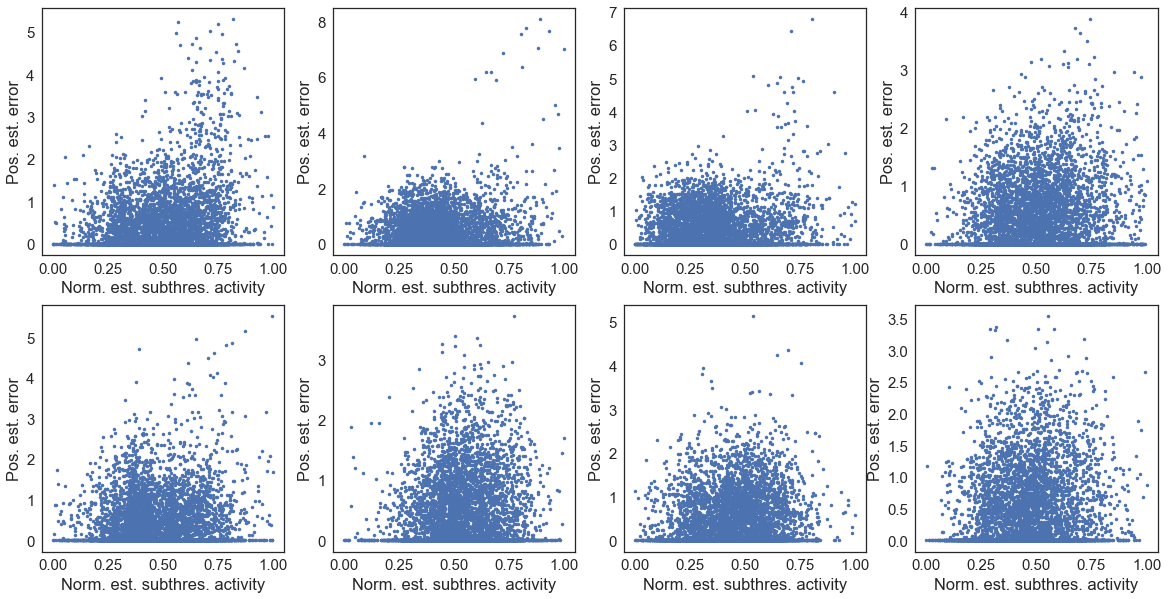

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
nTime = Y_stack.shape[0]
for spk, y, ax_ in zip(ROI_spike, ROI_traces, ax.flatten()):
    if len(y) == nTime:
        y_ = y.astype(np.double)
        x_sg = signal.savgol_filter(y, 511, 3)
        y_detr = -(y_ - x_sg)
        lam = lambda_max_D2(y_detr)
        x_, _, _ = lpdas(y_detr, lam/20, wi=None, z_hat=None, p = 1, m=5, delta_s=.9, delta_e=1.1, maxiter=2000, verbose=0)
        x_ = np.array(x_)
        diff = y_detr - x_
        diff = diff/diff.std()
        diff[diff<0] = 0
        x__ = (x_ - x_.min())/(x_.max() - x_.min())
        ax_.plot(x__, diff, '.')
        ax_.set_xlabel('Norm. est. subthres. activity')
        ax_.set_ylabel('Pos. est. error')
plt.show()

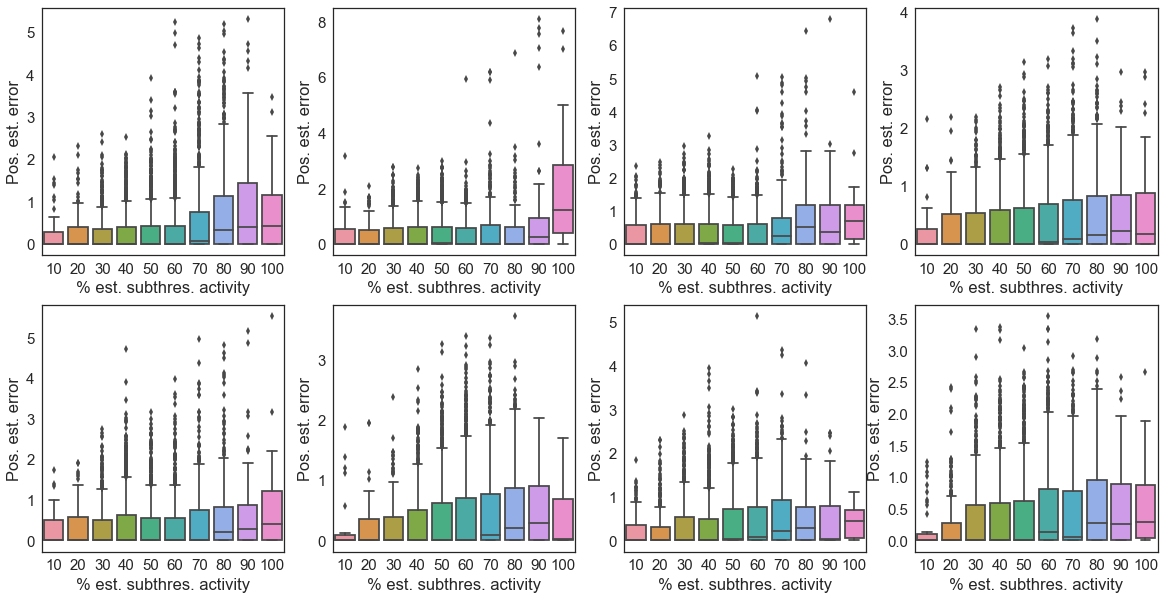

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for spk, y, ax_ in zip(ROI_spike, ROI_traces, ax.flatten()):
    y_ = y.astype(np.double)
    x_sg = signal.savgol_filter(y, 511, 3)
    y_detr = -(y_ - x_sg)
    lam = lambda_max_D2(y_detr)
    x_, _, _ = lpdas(y_detr, lam/20, wi=None, z_hat=None, p = 1, m=5, delta_s=.9, delta_e=1.1, maxiter=2000, verbose=0)
    x_ = np.array(x_)
    diff = y_detr - x_
    diff = diff/diff.std()
    diff[diff<0] = 0
    x__ = (x_ - x_.min())/(x_.max() - x_.min())
    x__ = (x__ * 10).astype(np.int)+1
    x__[x__==11] = 10
    sns.boxplot(x__*10, diff, ax=ax_)
    ax_.set_xlabel('% est. subthres. activity')
    ax_.set_ylabel('Pos. est. error')
plt.show()